An example of using gcamwrapper to highlight at a high level capabilities that could be useful for a number of tasks ranging from day to day work such as debgging or prototying, enabaling new expiriments such as coupling to other models, or new / more flexible method to run existing expiriments.

In [1]:
# common packages to support the demo
library(dplyr)
library(ggplot2)

# load GCAM via gcamwrapper
library(gcamwrapper)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




To interact with GCAM we create a GCAM object and to do that we need to simply provide a configuration XML and the appropriate working directory from which to run.

In [2]:
# path to the exe directory where gcam-core is installed
core_exe_path = 'exe'

# path to the xml configuration file you want to use
config_xml_file = 'configuration.xml'

Here we can observe the typical GCAM messages.  It will go through the steps of parsing all XMLs and other intitializations (`completeInit`) so that it is in a state that is ready to run model periods.

In [3]:
# %%time

g = create_and_initialize(config_xml_file, core_exe_path)

Running GCAM model code base version 7.1 revision gcam-v7.1

Configuration file:  configuration.xml
Parsing input files...
Parsing ./hector.xml scenario component.
Parsing ../../data/gcamdata/xml/socioeconomics_gSSP2.xml scenario component.
Parsing ../../data/gcamdata/xml/resources.xml scenario component.
Parsing ../../data/gcamdata/xml/en_supply.xml scenario component.
Parsing ../../data/gcamdata/xml/en_transformation.xml scenario component.
Parsing ../../data/gcamdata/xml/electricity_water.xml scenario component.
Parsing ../../data/gcamdata/xml/heat.xml scenario component.
Parsing ../../data/gcamdata/xml/hydrogen.xml scenario component.
Parsing ../../data/gcamdata/xml/en_distribution.xml scenario component.
Parsing ../../data/gcamdata/xml/other_industry.xml scenario component.
Parsing ../../data/gcamdata/xml/other_industry_incelas_gssp2.xml scenario component.
Parsing ../../data/gcamdata/xml/iron_steel.xml scenario component.
Parsing ../../data/gcamdata/xml/iron_steel_incelas_gssp2.x

Now we can start to interact with the GCAM object as we choose.  We will start by just running out several model periods.  `gcamwrapper` includes some handy utility methods such as to translate model years to periods.

In [4]:
run_period(g, convert_year_to_period(g, 2050))

Starting a model run. Running period 11
Model run beginning.
Period 0: 1975
Model solved with last period's prices.

Period 1: 1990
Model solved normally. Iterations period 1: 109. Total iterations: 110

Period 2: 2005
Model solved normally. Iterations period 2: 102. Total iterations: 211

Period 3: 2010
Model solved normally. Iterations period 3: 163. Total iterations: 374

Period 4: 2015
Model solved normally. Iterations period 4: 112. Total iterations: 485

Period 5: 2020
Model solved normally. Iterations period 5: 799. Total iterations: 1284

Period 6: 2025
Model solved normally. Iterations period 6: 186. Total iterations: 1470

Period 7: 2030
Model solved normally. Iterations period 7: 200. Total iterations: 1669

Period 8: 2035
Model solved normally. Iterations period 8: 159. Total iterations: 1828

Period 9: 2040
Model solved normally. Iterations period 9: 413. Total iterations: 2240

Period 10: 2045
Model solved normally. Iterations period 10: 148. Total iterations: 2387

Perio

Next I'll introduce the `SolutionDebugger` object which is also part of the `gcamwrapper` package.  Naturally it is useful for solution debugging.  Which may not be that interesting for most folks.  So I won't dwell on it.  It does however include a method, `evaluate`, which can be used to run a single iteration of GCAM.

In [5]:
# the default is to create the debugger at the last period run and all solvable markets
# however you could choose any previous period or supply a solution info using the same
# syntax as in the solver config such as:
# create_solution_debugger(g, market_filter = "solvable && unsolved")
sd = create_solution_debugger(g)

Save the initial prices so we can get back to them if necessary.

It is also a good time to point out that the solver wants to work in "scaled" or normalized units.  This of course isn't always meaningful to the modelers so the `SolutionDebugger` methods can be configured to give values in either `scaled` (`TRUE`) or actual units (`FALSE`).

In [6]:
x0 = get_prices(sd, TRUE)
prices0 = get_prices(sd, FALSE)

The `SolutionDebugger` methods return a vector of values.  However, these vectors are "named" with the market names which is quite handy to quickly understand what the values are

In [7]:
get_prices(sd, FALSE)[1:5]

globaloil-credits           USAcoal      USAcrude oil    USAnatural gas 
       -3.5087485         0.5608324         4.7748041         2.0317460 
    globaluranium 
       80.6822503

Or to index the vector directly

In [8]:
get_supply(sd, FALSE)['USACorn']

USACorn 
593.4747

A basic usage for this tool would be to map out supply and demand curves.

To do so we can organize the steps into a function which we can then call over a vector of prices and markets

In [9]:
calc_supply_demand = function(rel_prices, markets) {
    # loop over prices and colect results
    return_dfs = lapply(rel_prices, function(rel_price){
        # I like to scale prices using relative values
        # You could of course send actual prices in which case start with prices0
        x = x0
        x[markets] = x[markets] * rel_price
        
        # Now we can run an interation at this new price
        # We started from "scaled" prices so we need to tell evaluate so to let it know
        # it doesn't need to rescale them.
        # Also we don't want to reset the model back to the previous state so that we can
        # collect some additional information beyond the `F(x)` (demand - supply) which is
        # returned by the method
        fx = evaluate(sd, x, scaled = T, reset = F)
        
        # collect results in a DataFrame from which we can plot results later
        tibble(market=markets,
               price=get_prices(sd, F)[markets],
               fx=fx[markets],
               supply=get_supply(sd, F)[markets],
               demand=get_demand(sd, F)[markets])
    })
    bind_rows(return_dfs)
}

Change USA biomass prices from 50% to 500% the solved value evenly spaced over 50 points

In [10]:
bio_sd = calc_supply_demand(seq(0.5, 5.0, length.out=50), c("USAbiomass"))
head(bio_sd)

market,price,fx,supply,demand
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
USAbiomass,0.5533443,4.6257422,1.601397,42.17409
USAbiomass,0.6549790,3.9389913,1.974341,36.52349
USAbiomass,0.7566137,2.9594142,2.863243,28.82046
USAbiomass,0.8582483,1.9050127,4.238834,20.94783
USAbiomass,0.9598830,0.9781924,6.032081,14.61187
USAbiomass,1.0615177,0.2620572,7.907435,10.20596


Plot up the supply and demand curves

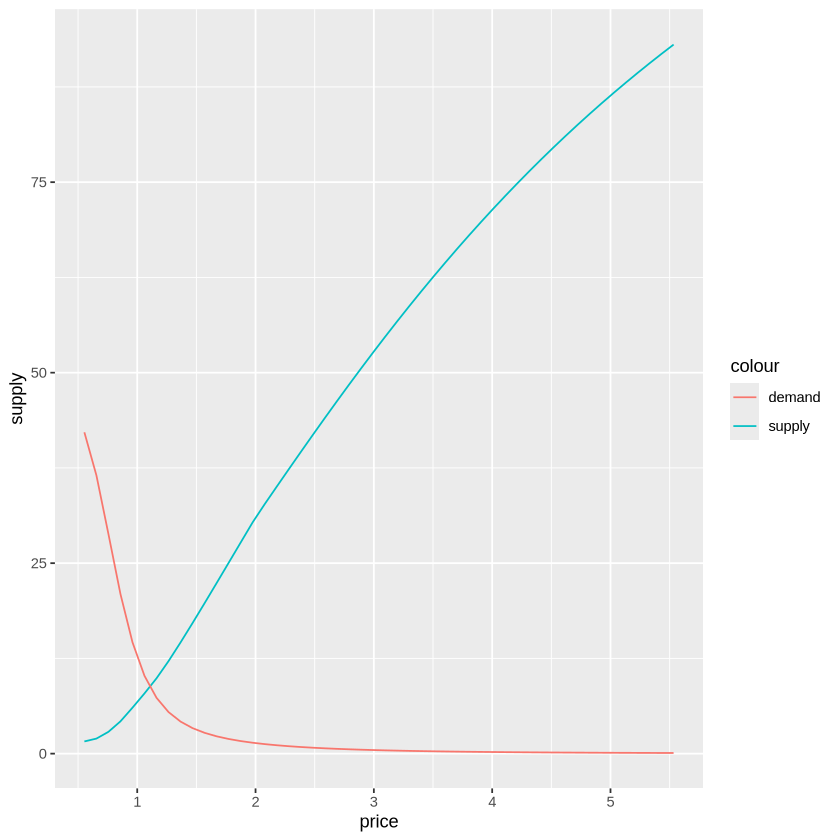

In [11]:
ggplot(bio_sd) + geom_line(aes(price, supply, color="supply")) + geom_line(aes(price, demand, color="demand"))

Now we switch gears and talk about how to get and set arbitrary GCAM parameters / results.

Given the heirarchical nature of the way this data is represented in GCAM we continue to need some sort of queries which look _something_ like XPath queries such as those used with the output databases.  So similar to the output database we include a Query library which we have pre-populated query library in a YAML file included with the `gcamwrapper` package.  However, given we are alredy in `R` where we can easily filter,  summarize, etc the queries tend to be less detailed.

In [12]:
PACKAGE_QUERIES <- yaml::read_yaml(system.file('extdata', 'query_library.yml', package="gcamwrapper"))

The queries have been organized into the following categores

In [13]:
names(PACKAGE_QUERIES)

[1] "resource"       "electricity"    "refining"       "buildings"     
 [5] "industry"       "transportation" "socioeconomic"  "emissions"     
 [9] "ag"             "land"           "water"          "market"

And with in these categores we see some common queries to get results such as outputs or inputs and parameters such as share weights, IO coefficients, or costs.

In [14]:
names(PACKAGE_QUERIES[['transportation']])

[1] "service"                "input"                  "sector_cost"           
[4] "tech_cost"              "subsector_share_weight" "tech_share_weight"     
[7] "input_coef"             "non_energy_cost"

Again the query looks something like XPath.  Altough you will note that in a bunch of these categories we see `region{region@name}` place holders.  These will basically be the columns you get in your output.  `gcamwrapper` will allow you to use some higher level sytax to apply filters in these place holders, but again, given the flexibility of doing this in `R` itself often just leaving the default (get all values) is good enough.

In [15]:
trn_cost_query = get_query('transportation', 'non_energy_cost')
trn_cost_query

[1] "world/region{region@name}/sector[+NamedFilter,StringRegexMatches,^trn_]/subsector{subsector@name}/technology{tech@name}/period{vintage@year}/input{input@name}/adjusted-cost{year@year}"
attr(,"units")
[1] "1975$/GJ"

We can then just call `get_data` on the GCAM object with the query we want.

In [16]:
trn_cost_df = get_data(g, trn_cost_query, list(vintage = c("=", get_current_year(g) ) ) )
head(trn_cost_df)

region,sector,subsector,technology,period,input,year,adjusted-cost
<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<dbl>
Africa_Eastern,trn_aviation_intl,International Aviation,BEV,2050,non-energy,2050,27.5957
Africa_Eastern,trn_aviation_intl,International Aviation,Hydrogen,2050,non-energy,2050,25.0106
Africa_Eastern,trn_aviation_intl,International Aviation,Liquids,2050,non-energy,2050,12.3702
Africa_Eastern,trn_freight,Domestic Ship,BEV,2050,non-energy,2050,3.7250
Africa_Eastern,trn_freight,Domestic Ship,FCEV,2050,non-energy,2050,1.5743
Africa_Eastern,trn_freight,Domestic Ship,Hybrid Liquids,2050,non-energy,2050,0.9313


Now lets use this capability to do something _interesting_.  Here we do a little experiment to scale our Core assumptions about battery / capital costs for battery electric vehicles and see what that does to fuel consumption in the transportation sector.

In [17]:
# save the core value so we can get back to it later
core_BEV = trn_cost_df %>% filter(technology == 'BEV')

Get the query for transport fuel consumption (input) and some mappings to aggregate / filter the fuels).

In [18]:
trn_fuel_map = tibble(fuel = c("H2", "H2", "coal", "gas", "elec", "liquids"),
                      input = c("H2 retail dispensing", "H2 wholesale dispensing",
                                  "delivered coal", "delivered gas", "elect_td_trn",
                                  "refined liquids enduse"))

trn_input_query = get_query("transportation", "input")

Organize the steps into a function so we can run the expirment over a vector of sensitiviy values.  Here we will do a simple test to see what happens as a first degree effect (out of equalibrium).

In [19]:
calc_bev_eval = function(sens_mults) {
    # loop over sensitivities and colect results
    return_dfs = lapply(sens_mults, function(sens){
        # start with the Core assumption and scale BEV costs by the current sens
        core_BEV %>%
            mutate(`adjusted-cost` = `adjusted-cost` * sens) %>%
            # to update the parameters in GCAM we can just call `set_data` with
            # the GCAM object, the DataFrame with values to update, and the same
            # query we used to query the data in the first place
            set_data(g, ., trn_cost_query)
        
        # run a single iteration using the solved prices
        # again, do not reset after so that we can collect some results
        evaluate(sd, x0, T, F)
        
        # grab the transport fuel consumption and aggregate so we can plot up some
        # results
        get_data(g, trn_input_query, list(year = c("=", get_current_year(g)))) %>%
         left_join(., trn_fuel_map, by=c("input")) %>%
         filter(!is.na(fuel)) %>%
         group_by(fuel) %>%
         summarize(`physical-demand` = sum(`physical-demand`)) %>%
         ungroup() %>%
         mutate(sens = sens)
    })
    bind_rows(return_dfs) %>%
        mutate(sens = factor(sens, levels=sens_mults))
}

Run the sensitivity at 1 (core value), 50%, and 10%

In [20]:
sens_out = calc_bev_eval(c(1.0, 0.5, 0.1))

Plot results

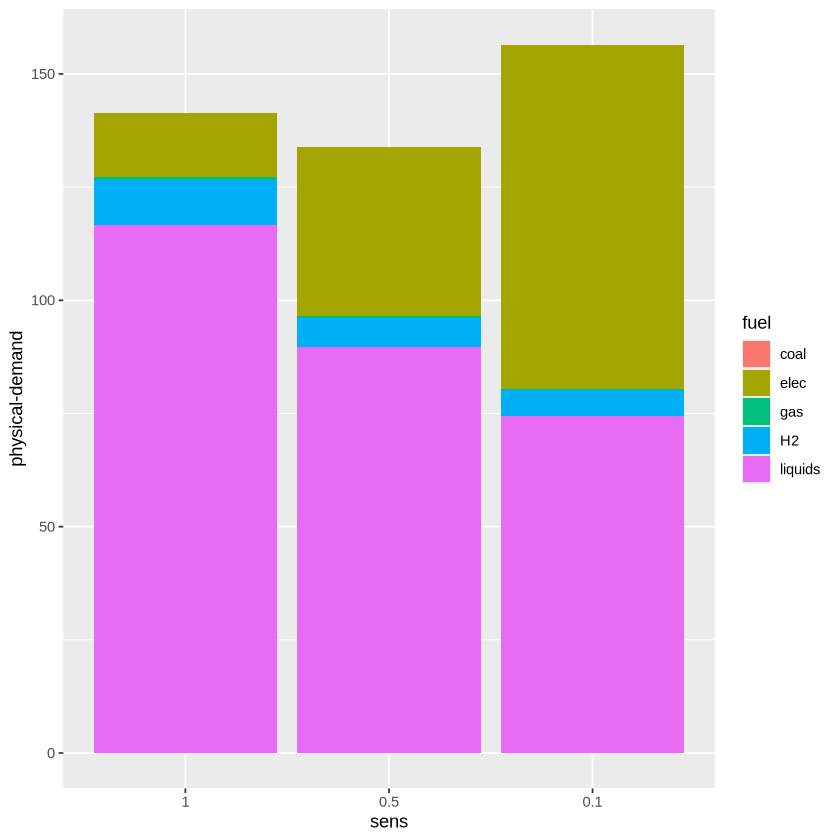

In [21]:
ggplot(sens_out) + geom_bar(aes(sens, `physical-demand`, fill = fuel), stat="identity")

Just double checking the costs indeed updated as expected

In [22]:
head(get_data(g, trn_cost_query, list(vintage = c("=", get_current_year(g)), tech = c("=", "BEV"))))

region,sector,subsector,technology,period,input,year,adjusted-cost
<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<dbl>
Africa_Eastern,trn_aviation_intl,International Aviation,BEV,2050,non-energy,2050,2.75957
Africa_Eastern,trn_freight,Domestic Ship,BEV,2050,non-energy,2050,0.37250
Africa_Eastern,trn_freight,Freight Rail,BEV,2050,non-energy,2050,2.10886
Africa_Eastern,trn_freight_road,Heavy truck,BEV,2050,non-energy,2050,0.04180
Africa_Eastern,trn_freight_road,Heavy truck,BEV,2050,non-energy,2055,0.04180
Africa_Eastern,trn_freight_road,Heavy truck,BEV,2050,non-energy,2060,0.04180


The real value of doing these experiments in GCAM is to include second order effects.  So lets do it again but this time re-solving.

In [23]:
calc_bev_solve = function(sens_mults) {
    # loop over sensitivities and colect results
    # Oops, we have to use a slightly different query otherwise the value we want
    # to set gets replaced with the parsed value in `initCalc`
    input_cost_query = 'world/region{region@name}/sector[+NamedFilter,StringRegexMatches,^trn_]/subsector{subsector@name}/technology{tech@name}/period{vintage@year}/input{input@name}/input-cost'
    return_dfs = lapply(sens_mults, function(sens){
        # start with the Core assumption and scale BEV costs by the current sens
        core_BEV %>%
            mutate(`adjusted-cost` = `adjusted-cost` * sens) %>%
            select(-year) %>%
            # set the data, same as before
            set_data(g, ., input_cost_query)
        
        # We can ask it to re-run whenever we want.  It keeps track of what has been
        # run already to this call will only re-run 2050.
        run_period(g, get_current_period(g))
        
        # grab the transport fuel consumption and aggregate so we can plot up some
        # results
        get_data(g, trn_input_query, list(year = c("=", get_current_year(g)))) %>%
         left_join(., trn_fuel_map, by=c("input")) %>%
         filter(!is.na(fuel)) %>%
         group_by(fuel) %>%
         summarize(`physical-demand` = sum(`physical-demand`)) %>%
         ungroup() %>%
         mutate(sens = sens)
    })
    bind_rows(return_dfs) %>%
        mutate(sens = factor(sens, levels=sens_mults))
}

Run the sensitivity at 1 (core value), 50%, and 10%

Obviously this will take longer to run

In [24]:
sens_out = calc_bev_solve(c(1.0, 0.5, 0.1))

Starting a model run. Running period 11
Model run beginning.
Period 11: 2050
Model solved normally. Iterations period 11: 291. Total iterations: 3022

All model periods solved correctly.
Model run completed.
Starting a model run. Running period 11
Model run beginning.
Period 11: 2050
Model solved normally. Iterations period 11: 159. Total iterations: 3181

All model periods solved correctly.
Model run completed.
Starting a model run. Running period 11
Model run beginning.
Period 11: 2050
Model solved normally. Iterations period 11: 181. Total iterations: 3362

All model periods solved correctly.
Model run completed.


Plot results

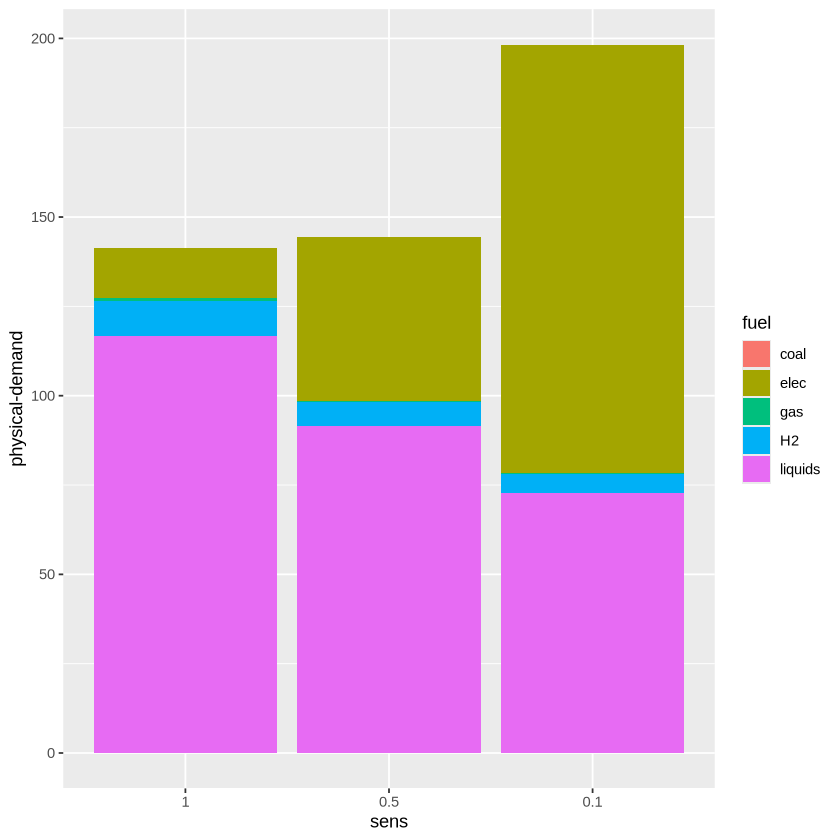

In [25]:
ggplot(sens_out) + geom_bar(aes(sens, `physical-demand`, fill = fuel), stat="identity")

Just double checking the costs indeed updated as expected

In [26]:
head(get_data(g, trn_cost_query, list(vintage = c("=", get_current_year(g)), tech = c("=", "BEV"))))

region,sector,subsector,technology,period,input,year,adjusted-cost
<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<dbl>
Africa_Eastern,trn_aviation_intl,International Aviation,BEV,2050,non-energy,2050,2.75957
Africa_Eastern,trn_freight,Domestic Ship,BEV,2050,non-energy,2050,0.37250
Africa_Eastern,trn_freight,Freight Rail,BEV,2050,non-energy,2050,2.10886
Africa_Eastern,trn_freight_road,Heavy truck,BEV,2050,non-energy,2050,0.04180
Africa_Eastern,trn_freight_road,Heavy truck,BEV,2050,non-energy,2055,0.04180
Africa_Eastern,trn_freight_road,Heavy truck,BEV,2050,non-energy,2060,0.04180
